In [1]:
import tensorflow as tf
from tensorflow import keras
import os
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
# Building Unet by dividing encoder and decoder into blocks
import os
import numpy as np
from keras.models import Model
from keras.layers import add,Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

train_path = 'C:\\Users\\Aayush Malde\\Desktop\\aayush documents\\TY KJSCE\\5th sem\\SC lab\\SC IA\\CHASE\\Train Images\\'
test_path ='C:\\Users\\Aayush Malde\\Desktop\\aayush documents\\TY KJSCE\\5th sem\\SC lab\\SC IA\\CHASE\\Test Images\\'
train_set_output='C:\\Users\\Aayush Malde\\Desktop\\aayush documents\\TY KJSCE\\5th sem\\SC lab\\SC IA\\CHASE\\Desired Output\\'
test_set_output='C:\\Users\\Aayush Malde\\Desktop\\aayush documents\\TY KJSCE\\5th sem\\SC lab\\SC IA\\CHASE\\Desired Output Test\\'

training_set = [train_path+i for i in os.listdir(train_path)]
testing_set = [test_path+i for i in os.listdir(test_path)]
train_set_output_set = [train_set_output+i for i in os.listdir(train_set_output)]
test_set_output_set = [test_set_output+i for i in os.listdir(test_set_output)]
# print(training_set)
# print(testing_set)
# print(train_set_output_set)

# ROWS= 512
# COLS= 512
# CHANNEL=3

# ROWS=128
# COLS=128
# CHANNEL=3

ROWS= 320
COLS= 320
CHANNEL=3

# ROWS= 256
# COLS= 256
# CHANNEL=3

In [3]:
def conv_block(input, num_filters):
    x=input
    for i in range(2):
        r = x 
        x = Conv2D(num_filters, 3,padding="same")(input)
        x = BatchNormalization()(x)   #Not in the original network. 
        x = Activation("relu")(x)
        x = Dropout(0.1)(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)  #Not in the original network
    
    shortcut= Conv2D(num_filters,kernel_size=(1,1),padding='same')(input)
    shortcut= BatchNormalization(axis=3)(shortcut)
    
    res_path = add([shortcut,x])
    x = Activation("relu")(res_path)
    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="R2U-Net")
    return model

In [4]:
def read_img(file_path):
    
    img = cv2.imread(file_path,cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS,COLS),interpolation=cv2.INTER_CUBIC)

def read_img1(file_path):
    
    img = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (ROWS,COLS),interpolation=cv2.INTER_CUBIC)

def prepare_data(images,images1):
    m = len(images) #18
    X = np.zeros((m,ROWS,COLS,CHANNEL),dtype = np.float32) #(18,572,572)
    Y = np.zeros((m,ROWS,COLS),dtype = np.float32)
    
    for i,image_file in enumerate(images):
        img = read_img(image_file)
        X[i]= img
    for i,image_file in enumerate(images1):
        img = read_img1(image_file)
        Y[i]= img
    return X, Y

In [5]:
train_set_x, train_set_y = prepare_data(training_set,train_set_output_set) 
test_set_x, test_set_y = prepare_data(testing_set,test_set_output_set)

# train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], ROWS*COLS*CHANNEL).T  #(7056,1000)
# test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], ROWS*COLS*CHANNEL).T

train_set_x = train_set_x/255
test_set_x = test_set_x/255

In [6]:
print(train_set_x.shape)

(20, 320, 320, 3)


In [9]:
# m = build_unet([128,128,3])
# m = build_unet([256,256,3])
# m = build_unet([512,512,3])
m = build_unet([320,320,3])
m.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
m.summary()


Model: "R2U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 320, 320, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 320, 320, 64) 256         conv2d_48[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 320, 320, 64) 0           batch_normalization_47[0][0]     
____________________________________________________________________________________________

In [15]:
checkpoint_filepath = 'C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/5th sem/SC lab/SC IA/tmp/weights3.best.hdf5'
epoch = 100
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
    save_best_only=True)
]

m = load_model('C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/5th sem/deeplearning/weights/weights3.best.hdf5')
results = m.fit(train_set_x,train_set_y,batch_size=8,validation_split=0.1,epochs = 10,callbacks=callbacks)
m.save('C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/5th sem/deeplearning/weights/weights3.best.hdf5')

Epoch 1/10
3/3 [==============================] - 99s 28s/step - loss: -268.8282 - accuracy: 0.5019 - val_loss: -123.4281 - val_accuracy: 0.1158
Epoch 2/10
3/3 [==============================] - 97s 27s/step - loss: -270.5985 - accuracy: 0.5045 - val_loss: -87.5662 - val_accuracy: 0.1664
Epoch 3/10
3/3 [==============================] - 93s 26s/step - loss: -271.6401 - accuracy: 0.4867 - val_loss: -32.1806 - val_accuracy: 0.6107
Epoch 4/10
3/3 [==============================] - 92s 26s/step - loss: -272.6403 - accuracy: 0.4903 - val_loss: 6.3007 - val_accuracy: 0.8754
Epoch 5/10
3/3 [==============================] - 94s 26s/step - loss: -273.1769 - accuracy: 0.4971 - val_loss: 6.9999 - val_accuracy: 0.8788
Epoch 6/10
3/3 [==============================] - 96s 27s/step - loss: -273.3793 - accuracy: 0.4769 - val_loss: -7.6343 - val_accuracy: 0.8521


In [16]:
accuracy = [0.29185113310813904, 0.3563140332698822, 0.3565717339515686, 0.37407225370407104, 0.38156577944755554, 0.43755581974983215, 0.4721435606479645, 0.49421441555023193, 0.5019574761390686, 0.5028943419456482]
accuracy += results.history['accuracy']
print(accuracy)

[0.29185113310813904, 0.3563140332698822, 0.3565717339515686, 0.37407225370407104, 0.38156577944755554, 0.43755581974983215, 0.4721435606479645, 0.49421441555023193, 0.5019574761390686, 0.5028943419456482, 0.5018918514251709, 0.5045377612113953, 0.48666664958000183, 0.4903266429901123, 0.49708494544029236, 0.47692540287971497]


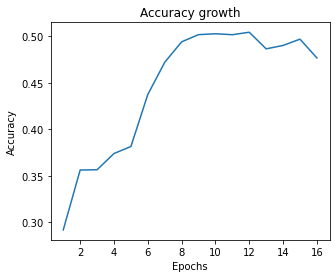

In [17]:
#plotting accuracy-epoch graph
x=[]
for i in range(1,len(accuracy)+1):
    x.append(i)
plt.plot(x, accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# set chart title
plt.title("Accuracy growth")
plt.show()

1/1 [==============================] - 16s 16s/step


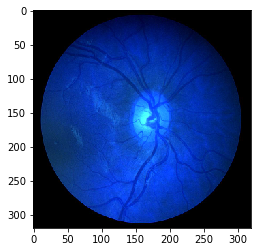

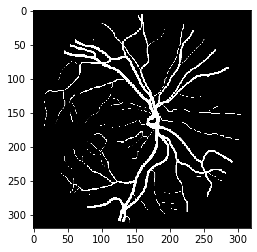

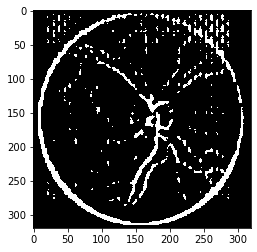

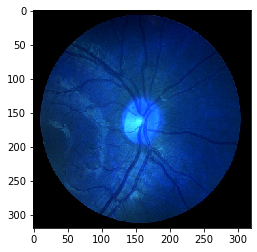

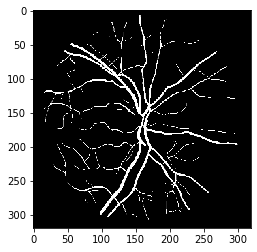

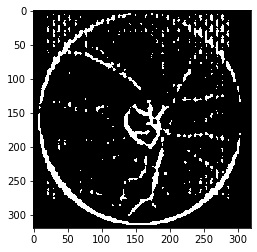

In [18]:

pred_train = m.predict(train_set_x[:int(train_set_x.shape[0]*0.9)],verbose=1)
pred_val = m.predict(train_set_x[:int(train_set_x.shape[0]*0.9)],verbose=1)

preds_train_t=(pred_train>0.5).astype(np.int32)
preds_val_t=(pred_val>0.5).astype(np.int32)

ix = 5
plt.imshow(train_set_x[ix])
plt.show()
plt.imshow(np.squeeze(train_set_y[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix=1
plt.imshow(train_set_x[int(train_set_x.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(train_set_y[int(train_set_y.shape[0]*0.9):][ix]))
plt.show()
plt.imshow(np.squeeze(preds_val_t[ix]))
plt.show()

1/1 [==============================] - 6s 6s/step
5


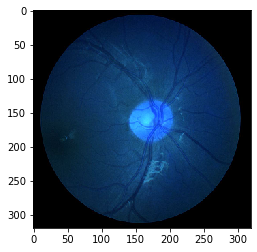

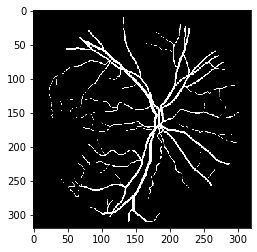

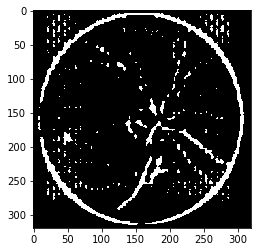

In [19]:
import random
# m = load_model('C:/Users/Aayush Malde/Desktop/aayush documents/TY KJSCE/5th sem/SC lab/SC IA/tmp/weights2.best.hdf5')
pred_test = m.predict(test_set_x[:int(test_set_x.shape[0]*0.9)],verbose=1)

pred_test_t=(pred_test>0.5).astype(np.int32)
ix = random.randint(1,6)
print(ix)
plt.imshow(test_set_x[ix])
plt.show()
plt.imshow(np.squeeze(test_set_y[ix]))
plt.show()
plt.imshow(np.squeeze(pred_test_t[ix]))
plt.show()